![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Satellite lake surface water temperature observations completeness for water resource management monitoring

Production date: 22-12-2025

Produced by: Cristina Deidda (VUB) and Victor Couplet (VUB)

## 🌍 Use case: Utilize satellite-derived lake water temperature data to water resources management and support climate adaptation strategies

## ❓ Quality assessment question
* **Are satellite measurements of surface water temperature adequately comprehensive in terms of temporal coverage and data completeness to monitor the temperature dynamics of Lake Superior (North America)?**

The [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset, available from 1995 to the present, provides a consistent time series of lake surface water temperature observations for lakes worldwide. These data support a wide range of applications, including water resource management, climate change impact assessment, fisheries management, and ecosystem monitoring. In this case study, we focus on Lake Superior and restrict the analysis to summer conditions (July–September). The objective is to assess the spatiotemporal completeness of the dataset, identify potential outliers, and evaluate its suitability for monitoring lake temperature dynamics and supporting these applications.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The completeness of satellite-derived lake surface water temperature (LSWT) data improves over time as satellite instrumentation evolves. For Lake Superior summer LSWT, data completeness (quality level ≥ 4) increases from less than 20 % prior to 2000 to approximately 40 % in recent years.
* At any given date, spatial data completeness over Lake Superior can range from 0 % to nearly 100 %, even with the most recent sensors. In contrast, when aggregated over the full 1995–2023 period, temporal data completeness is relatively spatially homogeneous across the lake.
* At fixed locations, temporal gaps in satellite observations can substantially hinder the monitoring of temperature variability and bias aggregated metrics such as mean summer LSWT. In some applications, incorporating lower-quality observations may be warranted, provided that robust outlier detection is applied.
```

## 📋 Methodology

We structure the analysis in the following steps, which are detailed in the sections below:

**[](satellite_satellite-lake-water-temperature_data-completeness_q01:section-1)**

* We download satellite lake surface water temperature (LSWT) data for the summer months (July–September) over the period 1995–2023.

**[](satellite_satellite-lake-water-temperature_data-completeness_q01:section-2)**

* We filter the dataset using lake identification masks and quality flags to retain both conservative (high-quality) and relaxed (low-to-high-quality) observations for Lake Superior.

**[](satellite_satellite-lake-water-temperature_data-completeness_q01:section-3)**

* To assess how spatial data completeness over Lake Superior evolves over time, we compute and plot the fraction of valid lake pixels for each summer season using both filtering strategies.
* We relate changes in spatial completeness to the timeline of satellite instruments contributing to the dataset.

**[](satellite_satellite-lake-water-temperature_data-completeness_q01:section-4)**

* To examine how temporal data completeness varies across the lake, we compute the fraction of valid observations at each lake pixel over the full 1995–2023 period.
* At locations corresponding to buoy sites, we compute annual mean summer LSWT from satellite data and compare these values with in situ buoy measurements to evaluate the impact of temporal gaps on aggregated metrics.
* We compare results obtained with the conservative and relaxed filters and identify situations in which including lower-quality data may improve temporal coverage without substantially degrading data reliability.

## 📈 Analysis and results

(satellite_satellite-lake-water-temperature_data-completeness_q01:section-1)=
### 1. Data request and download

#### Import packages

In [1]:
import cartopy.crs as ccrs
import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import cartopy.mpl.ticker as cticker
import numpy as np
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
import os
import requests, gzip
from tqdm import tqdm
from io import StringIO
from sklearn.metrics import mean_squared_error


plt.style.use("seaborn-v0_8-notebook")

#### Set variables

In [2]:
# Time
year_start = 1995
year_stop = 2023

# Region
lon_slice = slice(-92.10, -84.80)
lat_slice = slice(46.30, 49.00)

# Variable
varname = "lake_surface_water_temperature"

#### Set the data request

In [3]:
collection_id = "satellite-lake-water-temperature"
Requests = []
for year in range(year_start, year_stop + 1):
    Requests.append(
        {
            "variable": "all",
            "year": [str(year)],
            "month": ["07", "08", "09"],
            "day": [f"{day:02d}" for day in range(1, 32)],
            "version": ["4_5" if year < 2021 else "4_5_2"],
        }
    )

#### Download data

In [4]:
ds = download.download_and_transform(
    collection_id,
    Requests,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)

100%|██████████| 29/29 [00:01<00:00, 26.93it/s]


(satellite_satellite-lake-water-temperature_data-completeness_q01:section-2)=
### 2. Data preprocessing

We download satellite lake surface temperature data and visualize the water masses over the region spanning 46.30–49.00°N latitude and 92.10–84.80°W longitude. In the dataset, Lake Superior is identified by ID number 2. The locations of the three NOAA buoys used for data comparison are also plotted.

#### Plot lakeid

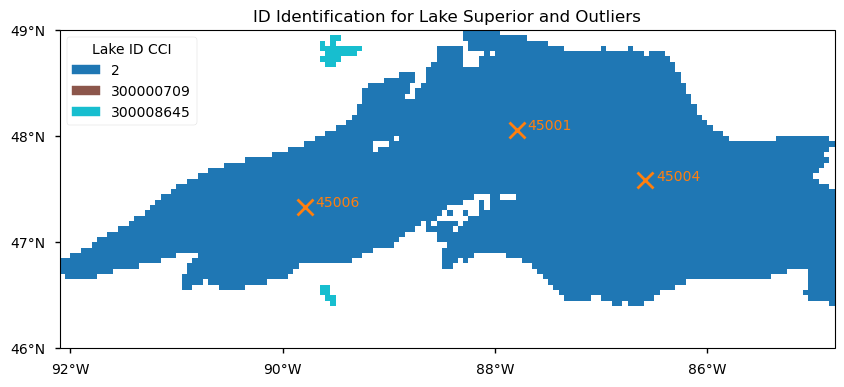

In [5]:
lakeid_data = ds['lakeid_CCI']
lats = ds['latitude']
lons = ds['longitude']

unique_ids = np.unique(lakeid_data.values[~np.isnan(lakeid_data.values)])
cmap = plt.get_cmap('tab10', len(unique_ids))

# ------------------------------------------------------------------
# Buoy coordinates (lon, lat)
buoy_coords = {
    "45006": (-89.793, 47.335),
    "45004": (-86.585, 47.585),
    "45001": (-87.793, 48.061),
}

# ------------------------------------------------------------------
# Plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    lons,
    lats,
    lakeid_data.isel(time=0),
    cmap=cmap,
    shading="auto",
    transform=ccrs.PlateCarree()
)

# ------------------------------------------------------------------
# Plot buoys
for name, (lon, lat) in buoy_coords.items():
    ax.plot(
        lon, lat,
        marker='x',
        color='C1',
        markersize=12,
        markeredgewidth=2,
        transform=ccrs.PlateCarree(),
        zorder=10
    )
    ax.text(
        lon + 0.1, lat,
        name,
        color='C1',
        fontsize=10,
        transform=ccrs.PlateCarree(),
        zorder=11
    )

# ------------------------------------------------------------------
# Longitude / latitude ticks
ax.set_xticks(np.arange(-92, -84, 2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(46, 50, 1), crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

ax.tick_params(labelsize=10)

# ------------------------------------------------------------------
# Legend for lake IDs
legend_handles = [
    mpatches.Patch(color=cmap(i / len(unique_ids)), label=str(int(uid)))
    for i, uid in enumerate(unique_ids)
]

ax.legend(
    handles=legend_handles,
    loc="upper left",
    title="Lake ID CCI",
    frameon=True
)

ax.set_title("ID Identification for Lake Superior and Outliers")

plt.show()

*Figure 1 : Lake Superior identification in the dataset. Locations of the three NOAA-NBDC buoys used for data comparison are shown as orange crosses.*

We construct a lake mask for the subsequent analyses, identifying a total of 4206 pixels associated with Lake Superior (Lake ID = 2).

In [6]:
lake_mask = ds["lakeid_CCI"].isel(time=0) == 2
lake_gridcell_count = lake_mask.sum(dim=["latitude", "longitude"]).values
print('Number of pixels associated with Lake Superior:',lake_gridcell_count)

Number of pixels associated with Lake Superior: 4206


#### Data filtering

The data are provided with 'quality flags' ranging from 0 to 5. Quality levels 4 and 5 reflect a higher degree of confidence in the validity of the satellite estimate. Users are advised to use the highest quality levels (4 and 5) in preference, unless they have specifically verified that lower quality levels are suitable for their application. Quality level 3 data, compared with in-situ data, may be acceptable to some users; however, they should be used with caution. Quality level 2 data is considered as the 'worst usable data' and should be thoroughly inspected if its use is strictly necessary (see section  4.2.4 of [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177) or section 3.4 of [ATBD](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800127#LSWTv4.5:AlgorithmTheoreticalBasisDocument(ATBD)-DeterminingQualityLevel)).

In the following analysis, we will use two quality filters:

- a **conservative filter** that retains data with quality levels 4 and 5 ;
- a **relaxed filter** that retains data with quality levels 2, 3, 4, and 5. 

In [7]:
# Reindex using lakeids and min_quality_level
lakeid = (
    xr.DataArray(np.unique(ds["lakeid_CCI"].values), dims=("lakeid_CCI"))
    .dropna("lakeid_CCI")
    .astype(int)
)
min_quality_level = xr.DataArray([2, 4], dims=("min_quality_level"))
ds = ds.drop_vars("lakeid_CCI").where(ds["lakeid_CCI"] == lakeid)
ds = ds.where(ds["lswt_quality_level"] >= min_quality_level)
ds = ds.assign_coords(lakeid_CCI=lakeid, min_quality_level=min_quality_level)

filtered_ds = ds.sel(lakeid_CCI=2, min_quality_level=4)
unfiltered_ds = ds.sel(lakeid_CCI=2, min_quality_level=2)

(satellite_satellite-lake-water-temperature_data-completeness_q01:section-3)=
### 3. Spatial completeness analysis

To assess the temporal evolution of spatial data completeness over Lake Superior, we compute, for each time step, the fraction of lake pixels containing valid LSWT observations using both the conservative and relaxed quality filters. Results are plotted in *Figure 2*.

In [8]:
def valid_percentage_time_series(ds, lake_gridcell_count, varname):
    valid_percentage = (
        100
        * ds[varname].notnull().sum(dim=["latitude", "longitude"])
        / lake_gridcell_count
    )

    valid_percentage = valid_percentage.assign_coords(
        month=valid_percentage["time"].dt.month
    )

    valid_percentage.attrs = {
        "long_name": "Valid LSWT",
        "units": "%",
    }

    return valid_percentage

def valid_percentage_summer_by_year(ds, lake_gridcell_count, varname):
    valid_percentage = (
        ds[varname].notnull().sum(dim=["latitude", "longitude"])
        .sel(time=ds.time.dt.month.isin([6, 7, 8]))
        .groupby("time.year")
        .mean() * 100/ lake_gridcell_count
    )

    valid_percentage.attrs = {
        "long_name": "Mean valid LSWT percentage (JJA)",
        "units": "%",
    }

    return valid_percentage

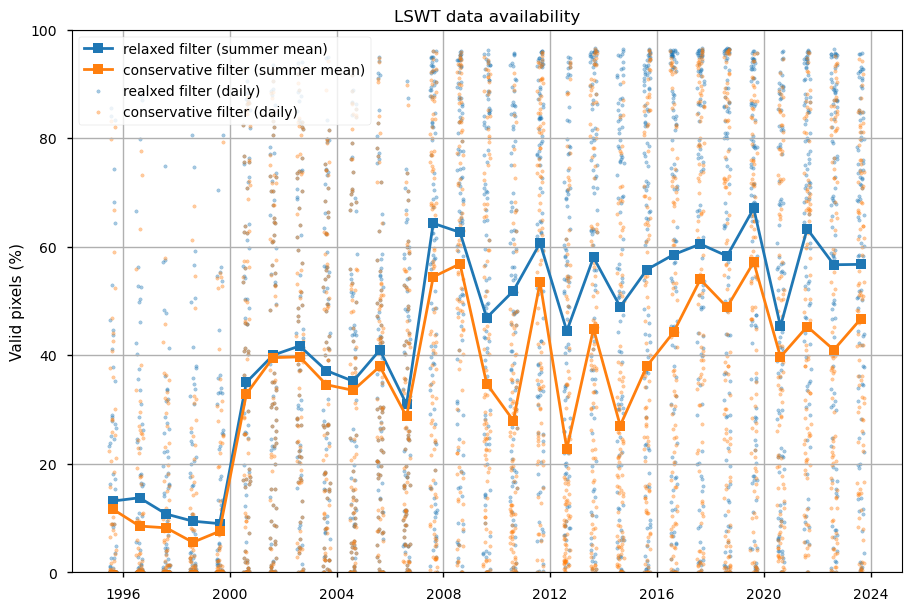

In [9]:
vp_unfiltered_summer = valid_percentage_summer_by_year(
    unfiltered_ds, lake_gridcell_count, varname
)

vp_filtered_summer = valid_percentage_summer_by_year(
    filtered_ds, lake_gridcell_count, varname
)

valid_percentage_summer = xr.concat(
    [vp_unfiltered_summer, vp_filtered_summer],
    dim=xr.DataArray(["relaxed filter", "conservative filter"], dims="filter"),
)

vp_unfiltered_ts = valid_percentage_time_series(
    unfiltered_ds, lake_gridcell_count, varname
)

vp_filtered_ts = valid_percentage_time_series(
    filtered_ds, lake_gridcell_count, varname
)

valid_percentage_ts = xr.concat(
    [vp_unfiltered_ts, vp_filtered_ts],
    dim=xr.DataArray(["realxed filter", "conservative filter"], dims="filter"),
)

# Convert year -> datetime (e.g. July 1st of each year)
summer_time = pd.to_datetime(
    valid_percentage_summer.year.astype(str) + "-08-15"
)

fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)

# Summer (aggregated)
for f in valid_percentage_summer.filter.values:
    ax.plot(
        summer_time,
        valid_percentage_summer.sel(filter=f),
        marker="s",
        linewidth=2,
        label=f"{f} (summer mean)",
    )

# Full time series
for f in valid_percentage_ts.filter.values:
    ax.scatter(
        valid_percentage_ts.time,
        valid_percentage_ts.sel(filter=f),
        s=6,
        alpha=0.4,
        label=f"{f} (daily)",
    )

ax.set_ylabel("Valid pixels (%)")
ax.set_title("LSWT data availability")
ax.set_ylim(0, 100)
ax.grid(True)
ax.legend()

plt.show()

*Figure 2: Temporal evolution of spatial data completeness for Lake Superior. Dots indicate the fraction of valid LSWT pixels for each day, while squares show the average fraction over the summer months (July–September).*

At any given date, spatial LSWT data completeness over Lake Superior can range from 0 % to nearly 100 %, even with the most recent satellite instruments (see *Figure 3*). When averaged over the summer months, however, data completeness generally improves over time as satellite instrumentation evolves. High-quality data (conservative filter, quality level ≥ 4) completeness increases from less than 20 % before 2000 to approximately 40 % in recent years. Using a relaxed filter (quality level ≥ 2) yields higher completeness, reaching around 60 % in recent summers, as fewer measurements are rejected. The marked increase in completeness around 2000 reflects the inclusion of MODIS observations from the Terra platform, whose wider swath allows more frequent observations of the same location. Similarly, the further increase around 2007 is associated with the incorporation of measurements from the AVHRR instruments (see *Figure 3*).

![image.png](e7a20759-c855-4da6-b79b-cec74596757f.png)

*Figure 3: Input data for the ESA CCI LAKES dataset (see Figure 1 from [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177)).*

(satellite_satellite-lake-water-temperature_data-completeness_q01:section-4)=
### 4. Temporal completeness analysis

#### Temporal completeness

To evaluate spatial variations in temporal data completeness over Lake Superior, we calculate, for each lake pixel, the fraction of valid observations across the full 1995–2023 period. The results for both conservative and relaxed filters are shown in Figure 4.

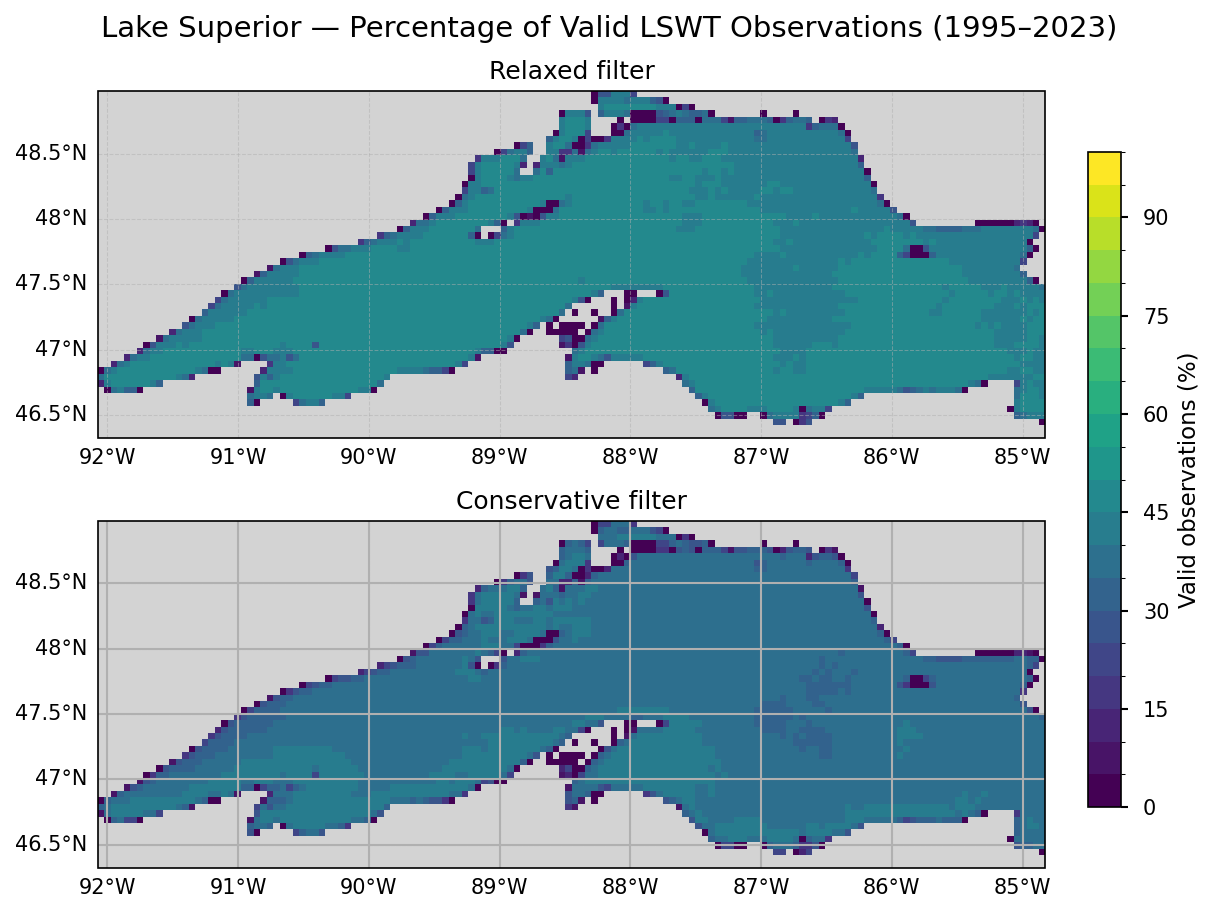

In [10]:
# --------------------------------------------------
# Parameters
# --------------------------------------------------
OUTSIDE_VALUE = -1.0  # below colormap range for non-lake pixels
bounds = np.arange(0, 101, 5)  # 0–100 %
cmap = plt.cm.viridis
norm = BoundaryNorm(bounds, cmap.N)

cmap.set_under("lightgray")  # outside lake
cmap.set_bad("white")        # lake but no valid data

# --------------------------------------------------
# Function to compute spatial valid percentage
# --------------------------------------------------
def valid_percentage_spatial(ds, varname, lake_mask):
    da = ds[varname]

    n_valid = da.notnull().sum(dim="time")
    n_total = da.sizes["time"]

    valid_pct = 100 * n_valid / n_total
    valid_pct = valid_pct.where(lake_mask, OUTSIDE_VALUE)

    return valid_pct

# --------------------------------------------------
# Compute maps
# --------------------------------------------------
valid_unfiltered = valid_percentage_spatial(unfiltered_ds, varname, lake_mask)
valid_filtered   = valid_percentage_spatial(filtered_ds, varname, lake_mask)

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, axes = plt.subplots(
    2, 1,
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree()},
    dpi=150,
    constrained_layout=True,
)

titles = ["Relaxed filter", "Conservative filter"]
maps = [valid_unfiltered, valid_filtered]

for ax, da, title in zip(axes, maps, titles):

    im = ax.imshow(
        da.values,
        origin="lower",
        cmap=cmap,
        norm=norm,
        extent=[
            float(da.longitude.min()),
            float(da.longitude.max()),
            float(da.latitude.min()),
            float(da.latitude.max()),
        ],
        transform=ccrs.PlateCarree(),
    )

    ax.coastlines()
    ax.set_title(title)

    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        linestyle="--",
        alpha=0.5,
    )
    gl.top_labels = gl.right_labels = False

# Remove left labels on right subplot
axes[1].gridlines().left_labels = False

# Shared colorbar
cbar = fig.colorbar(
    im,
    ax=axes,
    shrink=0.8,
    pad=0.04,
)
cbar.set_label("Valid observations (%)")

fig.suptitle(
    "Lake Superior — Percentage of Valid LSWT Observations (1995–2023)",
    fontsize=14,
)

plt.show()

*Figure 4: Temporal completeness of LSWT data at each Lake Superior pixel over the full 1995–2023 satellite record.*

When aggregated over the full 1995–2023 period, temporal data completeness is relatively homogeneous across Lake Superior. Areas of lower completeness are mainly found near land–water boundaries, likely reflecting limitations of the water/no-water classification algorithm (see section 1.2 of [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177)).

#### Comparison with buoy data

We compare the satellite data to in-situ buoy measurements to evaluate the impact of temporal gaps on aggregated metrics, such as the mean summer LSWT.

We download the buoy data from the NOAA National Data Buoy Center website [[1]](https://www.ndbc.noaa.gov/), which provides data by station and year. We developed a Python script that automatically downloads the data for buoys 45001, 45004, and 45006 for the years 1995-2023, and combines them into a single, unified dataset. 

We then avergae the buoy data over the summer months, and compare the results for each buoy to the summer mean temperature of the nearest satellite pixel corresponding to its location (see *Figure 5*).

In [11]:
def parse_noaa_text(text):
    """
    Parse NOAA stdmet text data.

    Args:
        text (str): Raw text from NOAA stdmet file.

    Returns:
        tuple: (columns_list, data_lines_str, header_line_index) or (None, None, None) if no header found.
    """
    lines = text.splitlines()

    # Find header: first non-empty line whose first token contains letters
    header_idx, header = next(
        ((i, ln.lstrip('#').strip()) for i, ln in enumerate(lines)
         if ln.strip() and any(ch.isalpha() for ch in ln.lstrip('#').split()[0])),
        (None, None)
    )

    if header is None:
        return None, None, None

    cols = header.split()
    # Extract data lines (non-empty, non-comment lines after header)
    data_lines = [ln.rstrip() for ln in lines[header_idx + 1:] if ln.strip() and not ln.lstrip().startswith('#')]

    return cols, "\n".join(data_lines), header_idx


def load_noaa_year(station, year, timeout=15):
    """
    Load one year of NOAA stdmet data for a given station.

    Args:
        station (str): NOAA station ID.
        year (int): Year to load.
        timeout (int): Requests timeout in seconds.

    Returns:
        pd.DataFrame: Columns ['datetime', 'WTMP'], or None if no usable data.
    """
    url = f"https://www.ndbc.noaa.gov/data/historical/stdmet/{station}h{year}.txt.gz"
    #print(f"Downloading {url} ...", end=" ")

    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        raw = gzip.decompress(r.content).decode("utf-8", errors="replace")
    except Exception as e:
        tqdm.write(f"\n → download error: {e}")
        return None

    cols, data_text, _ = parse_noaa_text(raw)
    if not cols or not data_text.strip():
        print(" → no usable header/data")
        return None

    try:
        df = pd.read_csv(
            StringIO(data_text),
            sep=r"\s+",
            names=cols,
            header=None,
            na_values=["MM", "99.0", "99", "999", "999.0", "9999"],
            comment="#",
            engine="python",
        )
    except Exception as e:
        print(f" → pandas read error: {e}")
        return None

    df.columns = [c.lstrip("#") for c in df.columns]

    # Ensure numeric columns for date/time
    for c in ("YY", "YYYY", "MM", "DD", "hh", "mm"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Determine proper year
    if "YYYY" in df.columns:
        df["YEAR"] = df["YYYY"]
    elif "YY" in df.columns or "#YY" in df.columns:
        yy_col = "YY" if "YY" in df.columns else "#YY"
        # If any 4-digit year present, treat as full year
        if df[yy_col].dropna().astype(str).str.len().gt(3).any():
            df["YEAR"] = df[yy_col]
        else:
            # 2-digit year: <50 -> 2000s, >=50 -> 1900s
            df["YEAR"] = df[yy_col].apply(lambda x: 2000 + x if x < 50 else 1900 + x)
    else:
        print(" → no recognizable year column")
        return None

    # Ensure minutes exist
    if "mm" not in df.columns:
        df["mm"] = 0

    # Build datetime column
    try:
        dt = pd.to_datetime(
            dict(year=df["YEAR"], month=df["MM"], day=df["DD"], hour=df["hh"], minute=df["mm"]),
            errors="coerce"
        )
    except Exception as e:
        print(f" → datetime conversion error: {e}")
        return None

    # Process WTMP
    if "WTMP" not in df.columns:
        print(" → WTMP column missing, skipping")
        return None
    df["WTMP"] = pd.to_numeric(df["WTMP"], errors="coerce")

    # Build output dataframe and filter invalid/extreme values
    out = pd.DataFrame({"datetime": dt, "WTMP": df["WTMP"]})
    out = out.dropna(subset=["datetime"])
    out = out[out["WTMP"].notna()]
    out = out[(out["WTMP"] > -5) & (out["WTMP"] < 50)]

    #print(f" → loaded {len(out)} rows")
    return out.reset_index(drop=True)


def load_noaa_range(stations, start_year=1979, end_year=2024):
    """
    Load NOAA data for multiple stations and years, with a progress bar.
    Returns a single DataFrame with a MultiIndex (station, datetime) and column 'WTMP'.
    """
    all_data = []
    total_steps = len(stations) * (end_year - start_year + 1)

    with tqdm(total=total_steps, desc="Overall progress") as pbar:
        for station in stations:
            for year in range(start_year, end_year + 1):
                pbar.set_postfix({"station": station, "year": year})
                df = load_noaa_year(station, year)
                if df is not None and not df.empty:
                    df["station"] = station
                    all_data.append(df)
                pbar.update(1)

    if not all_data:
        print("No data loaded for any station.")
        return pd.DataFrame(columns=["WTMP"], index=pd.MultiIndex.from_arrays([[], []], names=("station", "datetime")))

    # Concatenate all data
    full_df = pd.concat(all_data, ignore_index=True)

    # Set MultiIndex (station, datetime)
    full_df.set_index(["station", "datetime"], inplace=True)
    full_df.sort_index(inplace=True)

    print(f"Total rows loaded: {len(full_df)}")
    return full_df

In [12]:
stations = ["45001","45004","45006"]
buoy_data = load_noaa_range(stations, 1995, 2023)

Overall progress: 100%|██████████| 87/87 [01:09<00:00,  1.25it/s, station=45006, year=2023]

Total rows loaded: 643188


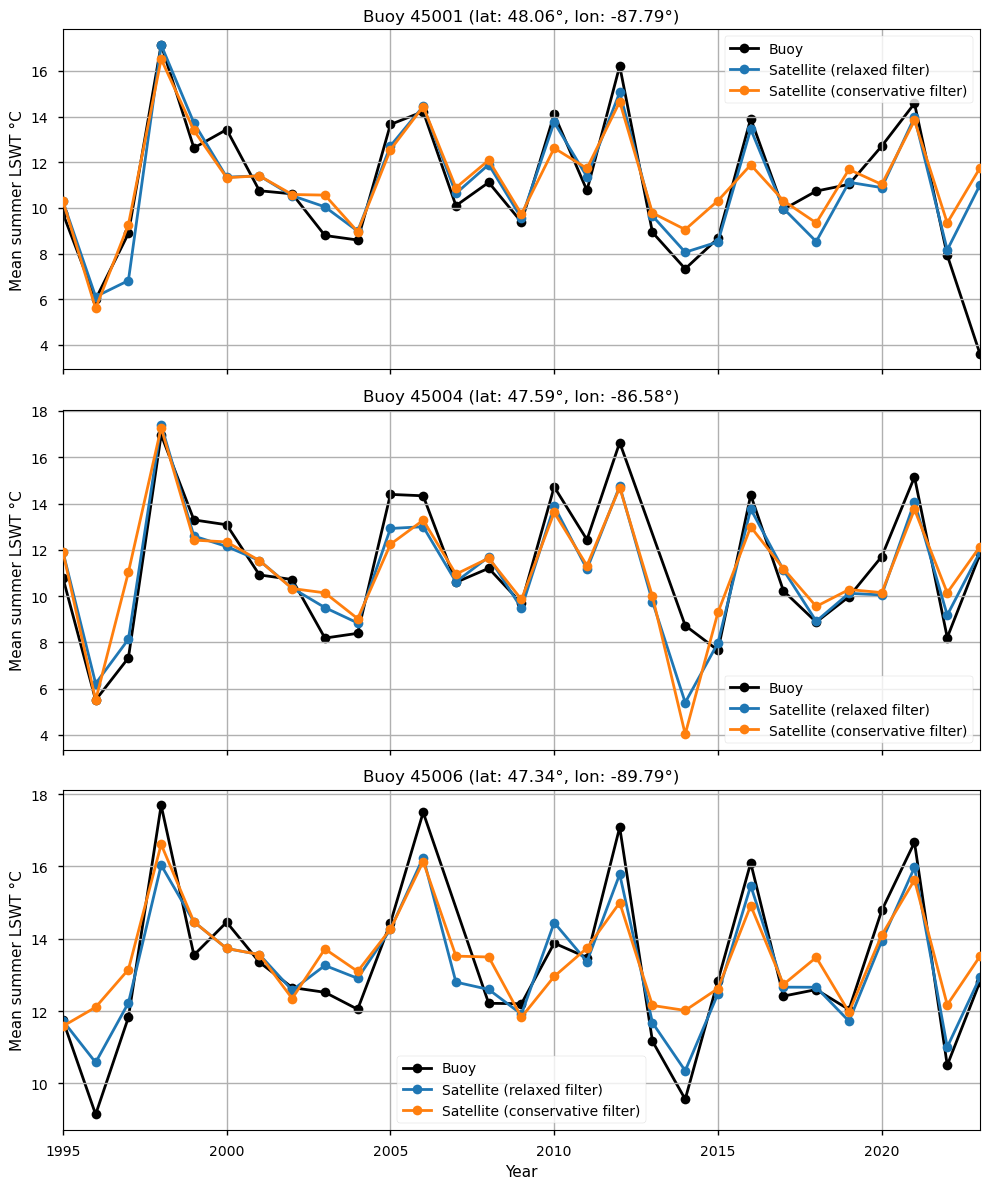

In [13]:
# Compare buoy, unfiltered, and filtered satellite summer mean temperatures

summer_months = [7, 8, 9]  # JAS

# Prepare buoy summer mean
buoy_df = (
    buoy_data
    .reset_index()
    .assign(
        year=lambda d: d["datetime"].dt.year,
        month=lambda d: d["datetime"].dt.month,
    )
)

summer_buoy = (
    buoy_df
    .loc[buoy_df["month"].isin(summer_months)]
    .groupby(["station", "year"], as_index=False)["WTMP"]
    .mean()
)

# Extract nearest-neighbor satellite temperature at each buoy position
sat_records_filtered = []
sat_records_unfiltered = []

for station, (lon, lat) in buoy_coords.items():

    # --- Filtered ---
    ts_filt = filtered_ds[varname].sel(longitude=lon, latitude=lat, method="nearest") - 273.15
    ts_filt_summer = ts_filt.sel(time=ts_filt["time.month"].isin(summer_months))
    ts_filt_mean = (
        ts_filt_summer.groupby("time.year").mean("time")
        .to_dataframe(name="sat_filtered_WTMP")
        .reset_index()
    )
    ts_filt_mean["station"] = station
    sat_records_filtered.append(ts_filt_mean)

    # --- Unfiltered ---
    ts_unfilt = unfiltered_ds[varname].sel(longitude=lon, latitude=lat, method="nearest") - 273.15
    ts_unfilt_summer = ts_unfilt.sel(time=ts_unfilt["time.month"].isin(summer_months))
    ts_unfilt_mean = (
        ts_unfilt_summer.groupby("time.year").mean("time")
        .to_dataframe(name="sat_unfiltered_WTMP")
        .reset_index()
    )
    ts_unfilt_mean["station"] = station
    sat_records_unfiltered.append(ts_unfilt_mean)

# Concatenate all stations into reusable tables
sat_summer_filtered = pd.concat(sat_records_filtered, ignore_index=True).sort_values(["station", "year"])
sat_summer_unfiltered = pd.concat(sat_records_unfiltered, ignore_index=True).sort_values(["station", "year"])

# -------------------------
# Plot comparison
# -------------------------
stations = summer_buoy["station"].unique()
fig, axes = plt.subplots(
    nrows=len(stations),
    ncols=1,
    figsize=(10, 4*len(stations)),
    sharex=True,
)

if len(stations) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, st in zip(axes, stations):

    s_buoy = summer_buoy.loc[summer_buoy["station"] == st]
    s_sat_filt = sat_summer_filtered.loc[sat_summer_filtered["station"] == st]
    s_sat_unfilt = sat_summer_unfiltered.loc[sat_summer_unfiltered["station"] == st]

    # Plot Buoy
    ax.plot(
        s_buoy["year"],
        s_buoy["WTMP"],
        marker="o",
        linewidth=2,
        label="Buoy",
        color='k',
        zorder=1
    )

    # Plot Unfiltered Satellite
    ax.plot(
        s_sat_unfilt["year"],
        s_sat_unfilt["sat_unfiltered_WTMP"],
        marker="o",
        linewidth=2,
        label="Satellite (relaxed filter)",
        color='C0',
        zorder=2
    )

    # Plot Filtered Satellite
    ax.plot(
        s_sat_filt["year"],
        s_sat_filt["sat_filtered_WTMP"],
        marker="o",
        linewidth=2,
        label="Satellite (conservative filter)",
        color='C1',
        zorder=3
    )

    lon, lat = buoy_coords[st]  # get coordinates
    ax.set_title(f"Buoy {st} (lat: {lat:.2f}°, lon: {lon:.2f}°)")
    ax.set_ylabel("Mean summer LSWT °C")
    ax.grid(True)
    ax.legend()
    ax.set_xlim((1995,2023))

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

*Figure 5: Mean summer LSWT for three Lake Superior buoys, compared to the mean summer LSWT from satellite data at the nearest pixel locations.* 

We observe that mean summer LSWT values derived from the satellite data are generally close to the buoy measurements, regardless of the quality filter applied. In several cases, the mean LSWT computed using the relaxed filter aligns more closely with the buoy mean than the conservative filter, for instance in 2016 for all three buoys. To quantify differences in performance between the two quality filters, we calculate the mean bias, mean absolute error (MAE), and root mean square error (RMSE) relative to the buoy observations.

In [14]:
def compute_sst_validation_metrics(df):
    """
    Compute satellite-vs-buoy SST validation metrics.

    Expects columns: ['station', 'year', 'buoy', 'sat'].

    Returns:
        pd.DataFrame with per-station metrics and a final 'ALL' row
        containing overall metrics.
    """

    rows = []

    # ---- Helper to compute metrics for any subset ----
    def metrics(sub):
        sat = sub["sat"].values
        buoy = sub["buoy"].values
        diff = sat - buoy

        bias = diff.mean()

        mae = np.mean(np.abs(diff))
        rmse = np.sqrt(mean_squared_error(buoy, sat))



        return {
            "n_samples": len(sub),
            "bias": bias,
            "MAE": mae,
            "RMSE": rmse,
        }

    # ---- Per-station metrics ----
    for st, sub in df.groupby("station"):
        row = {"station": st}
        row.update(metrics(sub))
        rows.append(row)

    # ---- Overall metrics (all stations pooled) ----
    overall = {"station": "ALL"}
    overall.update(metrics(df))
    rows.append(overall)

    return pd.DataFrame(rows)

In [15]:

# -------------------------------
# Prepare merged dataframes for metrics
# -------------------------------

# 1. Filtered satellite
df_diff_filtered = (
    summer_buoy
    .rename(columns={"WTMP": "buoy"})
    .merge(
        sat_summer_filtered.rename(columns={"sat_filtered_WTMP": "sat"}),
        on=["station", "year"],
        how="inner",
    )
)

metrics_filtered = compute_sst_validation_metrics(df_diff_filtered)
metrics_filtered["filter"] = "conservative"

# 2. Unfiltered satellite
df_diff_unfiltered = (
    summer_buoy
    .rename(columns={"WTMP": "buoy"})
    .merge(
        sat_summer_unfiltered.rename(columns={"sat_unfiltered_WTMP": "sat"}),
        on=["station", "year"],
        how="inner",
    )
)

metrics_unfiltered = compute_sst_validation_metrics(df_diff_unfiltered)
metrics_unfiltered["filter"] = "relaxed"

# 3. Combine metrics into single table
metrics_df = pd.concat([metrics_filtered, metrics_unfiltered], ignore_index=True)

pd.options.display.float_format = '{:.2f}'.format

display(metrics_df)

,station,n_samples,bias,MAE,RMSE,filter
0,45001,29,0.32,1.23,1.88,conservative
1,45004,28,-0.12,1.20,1.58,conservative
2,45006,28,0.21,0.95,1.18,conservative
3,ALL,85,0.14,1.13,1.58,conservative
4,45001,29,0.13,0.95,1.67,relaxed
5,45004,28,-0.26,0.86,1.10,relaxed
6,45006,28,-0.03,0.58,0.72,relaxed
7,ALL,85,-0.05,0.80,1.23,relaxed


Overall,the conservative high-quality satellite data show a small warm bias of 0.14 °C relative to the mean summer LSWT from buoy measurements. The corresponding MAE and RMSE are relatively large, at 1.13 °C and 1.58 °C, respectively. In contrast, the relaxed lower-quality data perform better across all metrics, with a slight cool bias of −0.05 °C, an MAE of 0.80 °C, and an RMSE of 1.23 °C.

To explore this further, we examine summer 2016 for buoy 45001 (see *Figure 6*). Only two high-quality satellite observations are available between late July and mid-August, a particularly warm period, whereas more than a dozen lower-quality observations are present throughout this interval. Despite their lower quality flag, these data closely match the buoy record and explain why the mean summer LSWT computed using the relaxed filter is higher than that from the conservative filter and more representative of the “true” mean indicated by the buoy measurements.

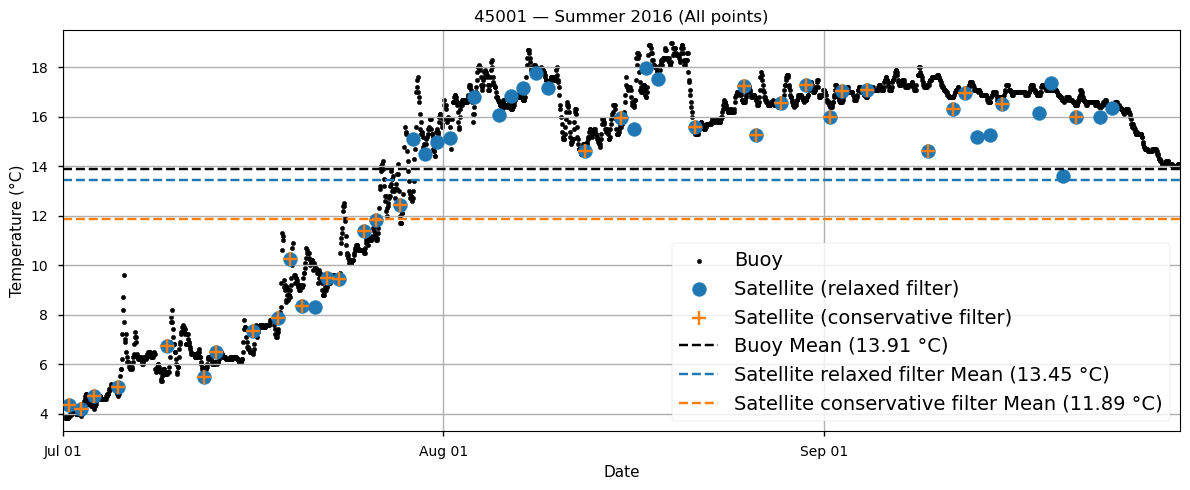

In [16]:

# --------------------------------------------------
# User inputs
# --------------------------------------------------
year = 2016
station = "45001"
summer_months = [7, 8, 9]

# Station coordinates
lon_gridcell, lat_gridcell = buoy_coords[station]

# --------------------------------------------------
# 1. All summer points for the station/year
# --------------------------------------------------
# Buoy: all summer points
df_buoy_all = buoy_data.reset_index()
df_buoy_all = df_buoy_all[
    (df_buoy_all['station'] == station) &
    (df_buoy_all['datetime'].dt.year == year) &
    (df_buoy_all['datetime'].dt.month.isin(summer_months))
].set_index('datetime')

# Satellite: unfiltered
ts_sat_unfiltered = (
    unfiltered_ds[varname]
    .sel(latitude=lat_gridcell, longitude=lon_gridcell, method='nearest')
    .sel(time=unfiltered_ds['time.year'] == year)
)
ts_sat_unfiltered = ts_sat_unfiltered.sel(time=ts_sat_unfiltered['time.month'].isin(summer_months)) - 273.15

# Satellite: filtered
ts_sat_filtered = (
    filtered_ds[varname]
    .sel(latitude=lat_gridcell, longitude=lon_gridcell, method='nearest')
    .sel(time=filtered_ds['time.year'] == year)
)
ts_sat_filtered = ts_sat_filtered.sel(time=ts_sat_filtered['time.month'].isin(summer_months)) - 273.15

# Means
mean_buoy = df_buoy_all['WTMP'].mean()
mean_sat_unfiltered = ts_sat_unfiltered.mean().compute().values
mean_sat_filtered = ts_sat_filtered.mean().compute().values

# --------------------------------------------------
# Shared y-axis limits
# --------------------------------------------------
ymin = min(df_buoy_all['WTMP'].min(), ts_sat_unfiltered.min().compute(), ts_sat_filtered.min().compute())
ymax = max(df_buoy_all['WTMP'].max(), ts_sat_unfiltered.max().compute(), ts_sat_filtered.max().compute())
pad = 0.5
ylim = (ymin - pad, ymax + pad)

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# ---- Date formatting ----
locator = mdates.MonthLocator()
formatter = mdates.DateFormatter("%b %d")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(pd.Timestamp(f"{year}-07-01"), pd.Timestamp(f"{year}-09-30"))

# ---- Scatter plots ----
# 1. Buoy points (background)
ax.scatter(df_buoy_all.index, df_buoy_all['WTMP'], color='k', s=10, label='Buoy', zorder=1)
# 2. Unfiltered satellite points
ax.scatter(ts_sat_unfiltered.time.values, ts_sat_unfiltered.values, color='C0', s=100, label='Satellite (relaxed filter)', zorder=2)
# 3. Filtered satellite points (on top)
ax.scatter(ts_sat_filtered.time.values, ts_sat_filtered.values, color='C1',marker='+', s=100, label='Satellite (conservative filter)', zorder=3)

# ---- Mean lines ----
ax.axhline(mean_buoy, color='k', linestyle='--', label=f'Buoy Mean ({mean_buoy:.2f} °C)')
ax.axhline(mean_sat_unfiltered, color='C0', linestyle='--', label=f'Satellite relaxed filter Mean ({mean_sat_unfiltered:.2f} °C)')
ax.axhline(mean_sat_filtered, color='C1', linestyle='--', label=f'Satellite conservative filter Mean ({mean_sat_filtered:.2f} °C)')

# ---- Labels, grid, legend ----
ax.set_title(f"{station} — Summer {year} (All points)")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Date")
ax.set_ylim(ylim)
ax.grid(True)
ax.legend(loc='lower right',fontsize=14)

plt.tight_layout()
plt.show()

*Figure 6: Comparison of buoy and satellite LSWT measurements for summer 2016 at the location of buoy 45001.* 

In general, including lower-quality observations increases temporal coverage, which can improve the estimation of aggregated quantities such as the mean summer LSWT. However, this comes with a trade-off: lower-quality data are more likely to include measurements that do not accurately represent true surface temperatures. In particular, cloud contamination can introduce spurious cold outliers that bias aggregated metrics. As a result, using relaxed quality filters can be advantageous during periods of sparse high-quality coverage, but it requires careful outlier screening to preserve the reliability of derived statistics.

To quantify the occurrence of spurious satellite measurements for both high- and low-quality data at buoy locations, we perform a direct comparison with the in-situ observations. Specifically, each satellite observation is paired with the nearest buoy measurement in time, provided the time difference is less than a specified tolerance (1 hour). If the absolute temperature difference exceeds 2 °C, the satellite observation is classified as an outlier. *Figure 7* shows, for each summer, the fraction of outliers relative to the total number of satellite observations obtained using the conservative and relaxed quality filters. 

In [17]:
def get_matched_buoy_sat(buoy_data, filtered_ds, varname, buoy_coords,
                          summer_months=[7, 8, 9], tolerance=pd.Timedelta('12h')):
    """
    Match buoy and satellite time series by timestamp within a tolerance for multiple stations.

    Args:
        buoy_data (pd.DataFrame): Buoy data with MultiIndex (station, datetime)
        filtered_ds (xarray.DataArray): Satellite data (Kelvin)
        varname (str): Name of variable in filtered_ds
        buoy_coords (dict): station -> (lat, lon)
        summer_months (list): List of summer months to consider
        tolerance (pd.Timedelta): Maximum allowed time difference for matching

    Returns:
        pd.DataFrame: Long-form DataFrame with columns
                      ['station', 'time', 'buoy', 'sat']
                      containing matched values for each station/time.
    """
    records = []

    # Flatten buoy data and add year/month
    df_buoy = buoy_data.reset_index()
    df_buoy['year'] = df_buoy['datetime'].dt.year
    df_buoy['month'] = df_buoy['datetime'].dt.month

    years = sorted(df_buoy['year'].unique())

    for st, (lon, lat) in buoy_coords.items():
        # Satellite at buoy location
        ts_sat = filtered_ds[varname].sel(latitude=lat, longitude=lon, method='nearest') - 273.15
        df_sat = ts_sat.to_dataframe(name='sat').dropna().reset_index()
        df_sat['year'] = df_sat['time'].dt.year
        df_sat['month'] = df_sat['time'].dt.month
        df_sat_summer = df_sat[df_sat['month'].isin(summer_months)].sort_values('time')

        # Buoy summer series
        df_buoy_st = df_buoy[(df_buoy['station'] == st) & (df_buoy['month'].isin(summer_months))]
        df_buoy_st = df_buoy_st[['datetime', 'WTMP']].sort_values('datetime')

        # Match satellite and buoy points year by year
        for yr in years:
            df_sat_year = df_sat_summer[df_sat_summer['year'] == yr]
            df_buoy_year = df_buoy_st[df_buoy_st['datetime'].dt.year == yr]
           
            if len(df_sat_year) > 0 and len(df_buoy_year) > 0:
                matched = pd.merge_asof(
                    df_sat_year,
                    df_buoy_year.rename(columns={'datetime': 'time'}),
                    on='time',
                    direction='nearest',
                    tolerance=tolerance
                ).dropna()

                for _, row in matched.iterrows():
                    records.append({
                        'station': st,
                        'time': row['time'],
                        'buoy': row['WTMP'],
                        'sat': row['sat']
                    })
        
    df_matched = pd.DataFrame(records)
    return df_matched

In [18]:
df_matched = get_matched_buoy_sat(
    buoy_data=buoy_data,
    filtered_ds=filtered_ds,
    varname=varname,
    buoy_coords=buoy_coords,
    summer_months=[7, 8, 9],
    tolerance=pd.Timedelta('1h')
)

df_matched_unfiltered = get_matched_buoy_sat(
    buoy_data=buoy_data,
    filtered_ds=unfiltered_ds,
    varname=varname,
    buoy_coords=buoy_coords,
    summer_months=[7, 8, 9],
    tolerance=pd.Timedelta('1h')
)

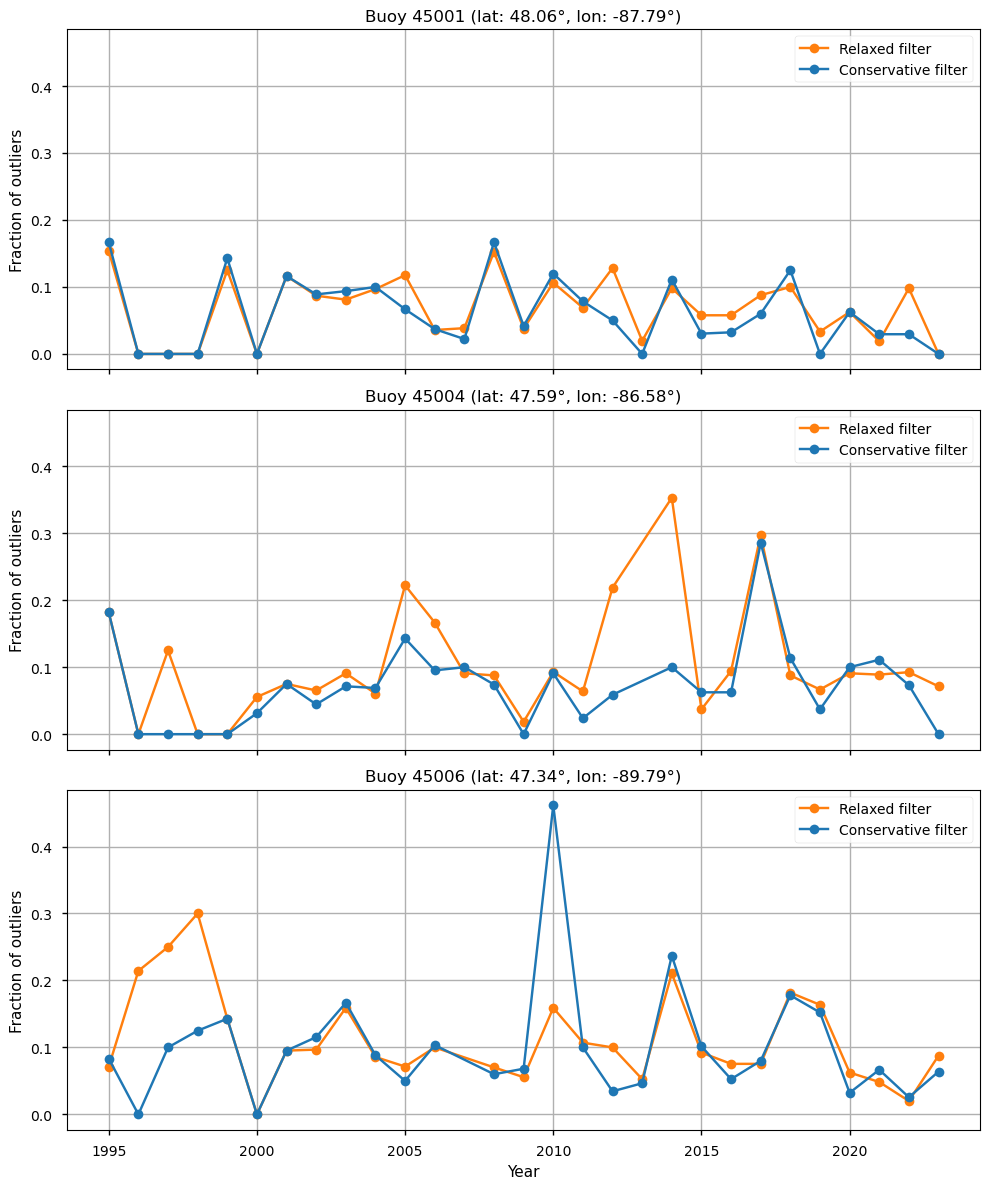

In [19]:
# -------------------------------
# Parameters
# -------------------------------
deltaT = 2.0  # °C difference to define an outlier
stations = df_matched['station'].unique()[::-1]

# -------------------------------
# Function to compute fraction of outliers per year
# -------------------------------
def compute_outlier_fraction(df, deltaT=2.0):
    df = df.copy()
    df['outlier'] = np.abs(df['sat'] - df['buoy']) > deltaT
    df['year'] = df['time'].dt.year
    summary = (
        df.groupby(['station', 'year'])
        .agg(n_outliers=('outlier', 'sum'),
             n_total=('outlier', 'count'))
        .reset_index()
    )
    summary['fraction_outliers'] = summary['n_outliers'] / summary['n_total']
    return summary

frac_outliers_filtered = compute_outlier_fraction(df_matched, deltaT=deltaT)
frac_outliers_unfiltered = compute_outlier_fraction(df_matched_unfiltered, deltaT=deltaT)

# -------------------------------
# Plot fraction of outliers per station
# -------------------------------
fig, axes = plt.subplots(len(stations), 1, figsize=(10, 4*len(stations)), sharex=True,sharey=True)

if len(stations) == 1:
    axes = [axes]  # ensure iterable

for ax, st in zip(axes, stations):
    df_f = frac_outliers_filtered[frac_outliers_filtered['station'] == st]
    df_u = frac_outliers_unfiltered[frac_outliers_unfiltered['station'] == st]

    ax.plot(df_u['year'], df_u['fraction_outliers'], marker='o', linestyle='-', color='C1', label='Relaxed filter')
    ax.plot(df_f['year'], df_f['fraction_outliers'], marker='o', linestyle='-', color='C0', label='Conservative filter')

    lon, lat = buoy_coords[st]  # get coordinates
    ax.set_title(f"Buoy {st} (lat: {lat:.2f}°, lon: {lon:.2f}°)")
    ax.set_ylabel("Fraction of outliers")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

*Figure 7: Fraction of satellite LSWT observations classified as outliers at buoy locations for each summer, shown separately for the conservative (quality level ≥ 4) and relaxed (quality level ≥ 2) filters. Outliers are defined as satellite observations differing by more than 2 °C from the nearest-in-time buoy measurement (within a 1-hour tolerance)*

We find that, for most years, the fraction of outliers associated with the relaxed filter is not substantially higher than that of the conservative filter. This explains why, in this specific case, using a relaxed quality filter yields more accurate estimates of the mean summer LSWT for Lake Superior than a conservative filter. However, this result may not generalize to other lakes, and users should evaluate whether including lower-quality data is appropriate for their application. In practice, outliers can be identified using statistical methods applied directly to the satellite time series, without relying on in-situ observations.

## ℹ️ If you want to know more

### Key resources


Dataset documentation:

* [ATBD](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800127#LSWTv4.5:AlgorithmTheoreticalBasisDocument(ATBD)-DeterminingQualityLevel): Algorithm Theoretical Basis Document (ATBD)
* [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177): Product User Guide and Specification (PUGS)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://www.ndbc.noaa.gov/) NOAA National Buoy Data Centre.